## import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import re
import requests
import csv
import tensorflow as tf
import math
import random


from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.utils import Sequence

In [55]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [57]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


## **Sequence class for data load**

load dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaiska/apparel-dataset")

print("Path to dataset files:", path)

100%|██████████| 161M/161M [00:08<00:00, 20.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kaiska/apparel-dataset/versions/2


In [32]:
class Dataset(Sequence):
    def __init__(self, paths: str, batch_size: int):
        super(Dataset, self).__init__()
        self.batch_size = batch_size
        self.__data = paths
        self.classes = []
        self.__labels = self.__list_labels(self.__data)



    def __len__(self):
        return math.ceil(len(self.__data) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.__data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.__labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([self.__load_image(i) for i in batch_x]), np.array(batch_y)

    def __list_labels(self, paths: list):
        labels = []
        for path in paths:
            label = path.split(os.path.sep)[-2].split('_')
            #label = path.split(os.path.sep)[-2].split(' ')
            labels.append(label)

        mlb = MultiLabelBinarizer()
        labels = mlb.fit_transform(labels)
        self.classes = mlb.classes_

        return labels

    @staticmethod
    def __load_image(path: str):
        img = cv.imread(path)
        img = cv.resize(img, (224,224))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return img / 255.0

## split Training and testing path

In [5]:
train_size = 0.8
paths = []
path_to_subset = '/root/.cache/kagglehub/datasets/kaiska/apparel-dataset/versions/2'
for folder in os.listdir(path_to_subset):

    for image in os.listdir(os.path.join(path_to_subset, folder)):
        path_to_image = os.path.join(path_to_subset, folder, image)

        #check image none or not none
        img = cv.imread(path_to_image)
        if img is not None:
          paths.append( path_to_image)

paths = sorted(paths)
paths[0]
random.shuffle(paths)
assert 0.0 < train_size <= 1.0
thresh = round(len(paths) * train_size)
train_paths = paths[:thresh]
test_paths = paths[thresh:]
print(train_paths[0], test_paths[1])

/root/.cache/kagglehub/datasets/kaiska/apparel-dataset/versions/2/black_dress/158.jpg /root/.cache/kagglehub/datasets/kaiska/apparel-dataset/versions/2/pink_hoodie/000043.jpg


In [6]:
print("Total image :",len(paths))
print(f"Training image path length {len(train_paths) }, Validation image path length {len(test_paths) }")

Total image : 16170
Training image path length 12936, Validation image path length 3234


## Model architec

In [39]:
def define_model(input_shape,len_class:int):
  model = tf.keras.models.Sequential()

  model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization()) #Stack of images become stack with no negative values
  model.add(MaxPooling2D(3))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(1024, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))


  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu', kernel_initializer = 'he_normal', ))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.summary()
  model.add(Dense(len_class, activation = 'sigmoid'))
  return model

## Define model checkpoints to save best model

In [34]:
# Define the directory and filename for saving the best model
model_filename = 'Dress_MLC_CNN.keras'

# Combine the directory and filename
model_path = model_filename

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', verbose=1)

In [35]:
best_weights = ModelCheckpoint('Dress_MLC_CNN.weights.h5',
                               monitor='val_loss',
                               verbose=0,
                               save_weights_only=True,
                               save_best_only=True,
                               mode='min',
                               save_freq='epoch')


last_weights = ModelCheckpoint('Dress_MLC_CNN.weights.h5',
                               monitor='val_loss',
                               verbose=0,
                               save_weights_only=True,
                               save_best_only=False,
                               mode='auto',
                               save_freq='epoch')

# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       restore_best_weights=True,
                                       verbose=1)

## Define Dataset class instance and compile model

In [40]:
input_shape = (224,224, 3)

train_ds = Dataset(train_paths, batch_size=32)
test_ds = Dataset(test_paths, batch_size=32)

len_class=17

model = define_model(input_shape,len_class)
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 74, 74, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 74, 74, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 74, 74, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 30,431,616 (116.09 MB)

 Trainable params: 30,415,424 (116.03 MB)

 Non-trainable params: 16,192 (63.25 KB)

In [13]:
print("training image batch:",train_ds[0][0])
print("training labels batch:",train_ds[0][1])

training image batch: [[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.      

In [20]:
#save class
for i in range(len(train_ds.classes)):
    classes= '\n'.join(train_ds.classes)

with open('classes.txt', 'w') as f:
    f.write(classes)

#save model architectue as jason format

architecture_json = model.to_json()

with open('model_architecture.json', 'w') as json_file:
    json_file.write(architecture_json)


print(train_ds.classes)

['black' 'blue' 'brown' 'dress' 'green' 'hoodie' 'pants' 'pink' 'red'
 'shirt' 'shoes' 'shorts' 'silver' 'skirt' 'suit' 'white' 'yellow']


## Train model

In [41]:
with tf.device('/GPU:0'):
  history = model.fit(x=train_ds,
                      validation_data=test_ds,
                      steps_per_epoch=len(train_ds),
                      epochs = 50,
                      verbose = 1,
                      callbacks = [checkpoint,best_weights,early_stopping_callback])


Epoch 1/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 101s 192ms/step - accuracy: 0.2963 - loss: 0.4350 - val_accuracy: 0.2319 - val_loss: 0.3114
Epoch 2/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 56s 139ms/step - accuracy: 0.4390 - loss: 0.1333 - val_accuracy: 0.3318 - val_loss: 0.2021
Epoch 3/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.4406 - loss: 0.1065 - val_accuracy: 0.3581 - val_loss: 0.0927
Epoch 4/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 57s 141ms/step - accuracy: 0.4341 - loss: 0.0780 - val_accuracy: 0.5031 - val_loss: 0.1180
Epoch 5/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - accuracy: 0.4554 - loss: 0.0678 - val_accuracy: 0.3466 - val_loss: 0.0787
Epoch 6/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 56s 137ms/step - accuracy: 0.4412 - loss: 0.0565 - val_accuracy: 0.3602 - val_loss: 0.1009
Epoch 7/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 83s 139ms/step - accuracy: 0.4452 - loss: 0.0558 - val_accuracy: 0.4780 - val_loss: 0.0928
Epoch 8/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 56s 139ms/step - accuracy: 0.4561 - loss: 

## Training stat

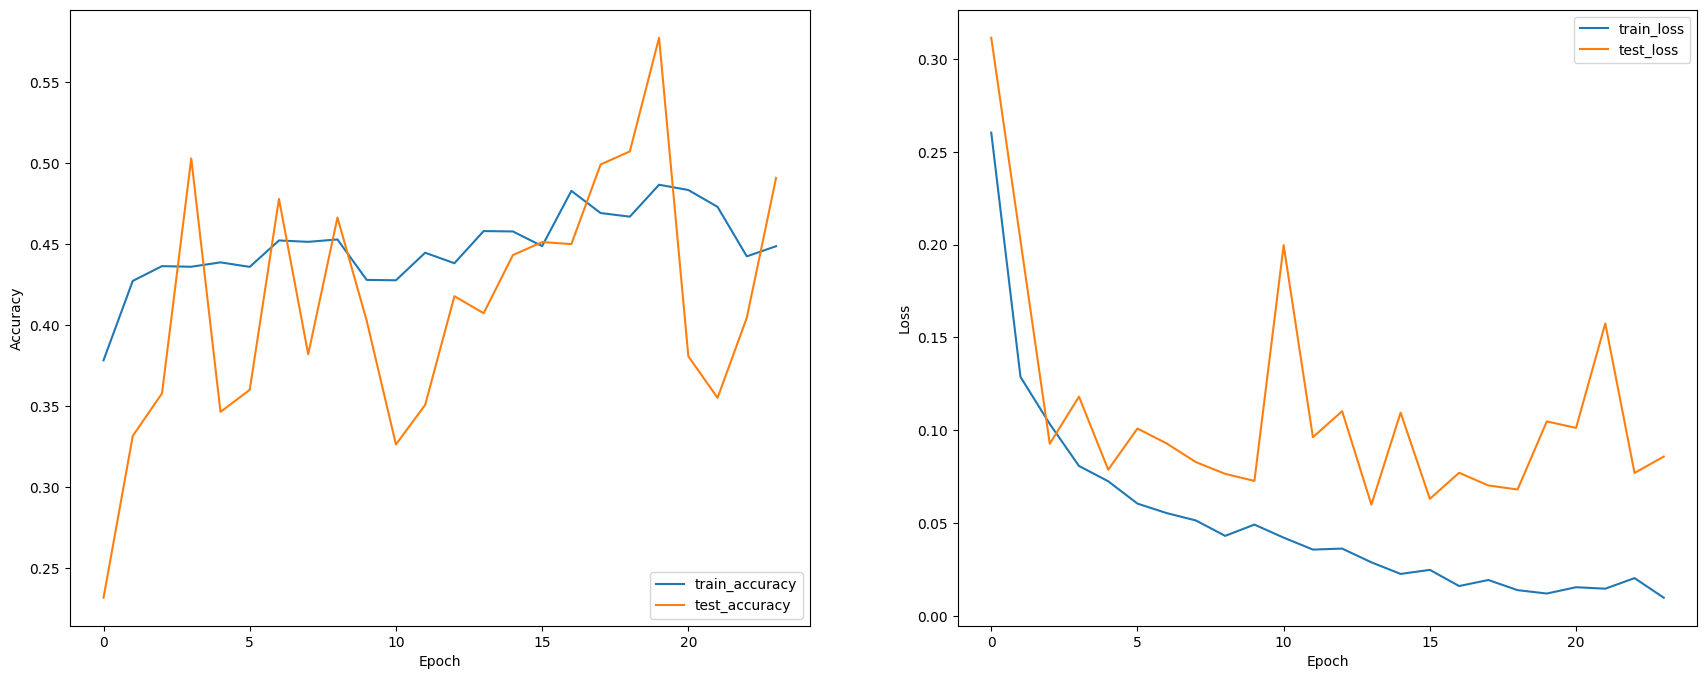

In [42]:
plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label='train_loss')
plt.plot(history.history["val_loss"], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Model inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[('blue', 0.99999976), ('shirt', 0.99999964), ('green', 1.7883733e-06)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[('blue', 0.97848654), ('dress', 0.6332556), ('shorts', 0.014835929)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[('black', 0.9906193), ('shirt', 0.9353695), ('suit', 0.0061748354)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[('white', 0.99993753), ('shoes', 0.7098046), ('dress', 0.009516622)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[('white', 0.9965461), ('pants', 0.9896541), ('blue', 0.014087641)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[('red', 0.99997675), ('dress', 0.9988331), ('hoodie', 0.0007795009)]


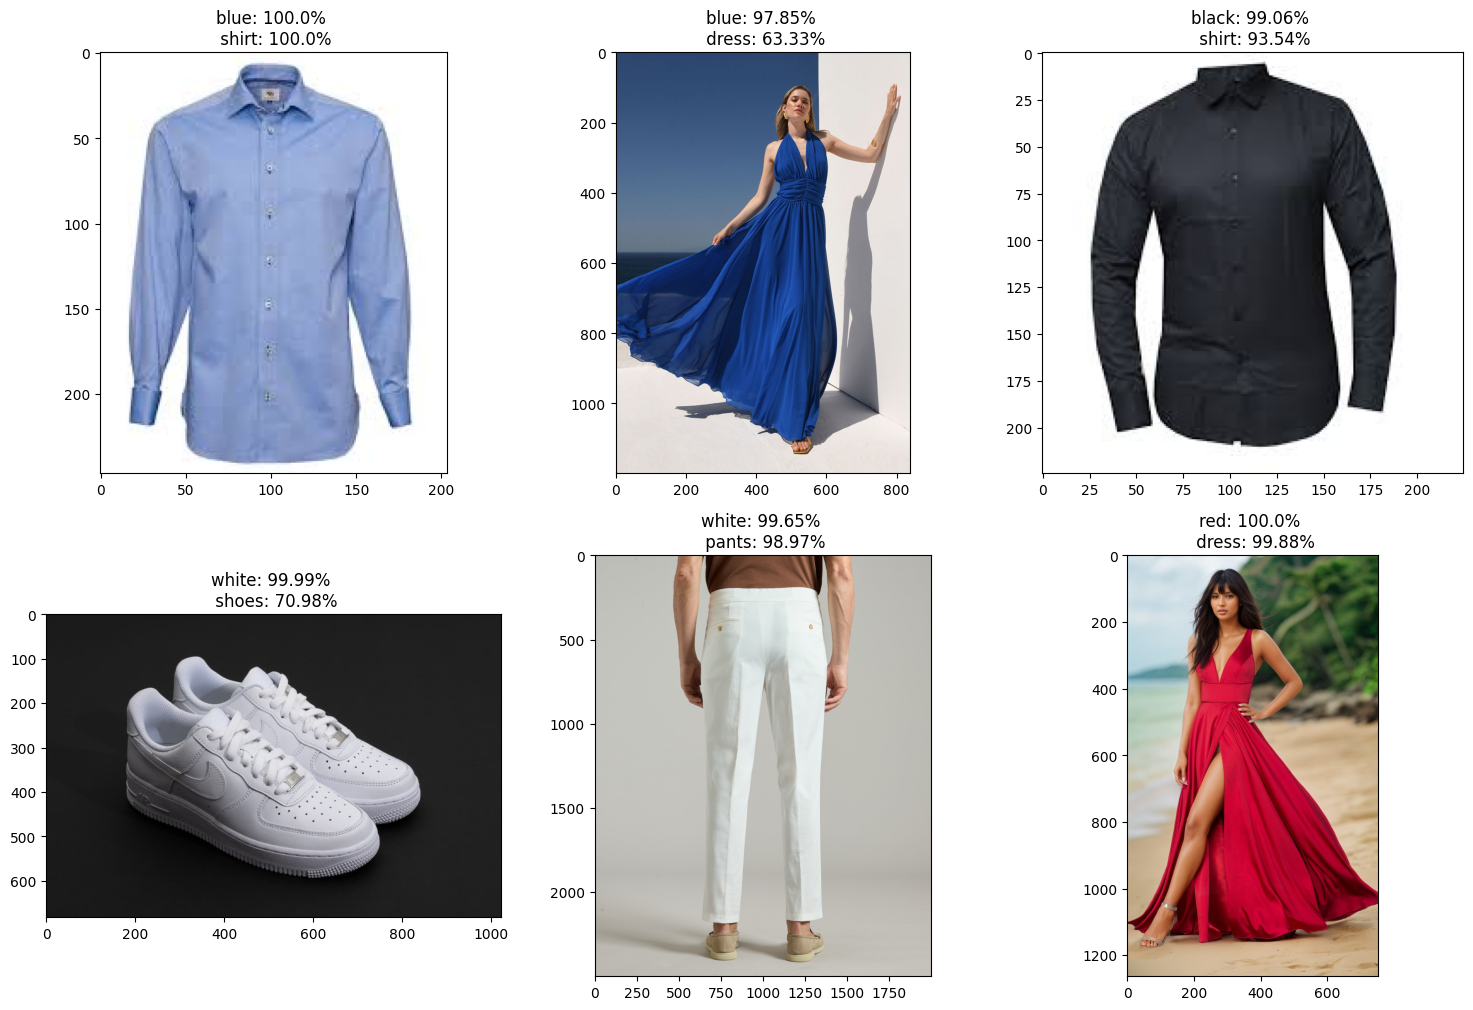

In [54]:
# URLs to images
urls = ["https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBddm7UOg5sD7wgjTLA80F4t0DZ13lBNo-Vw&s",
        "https://www.nashbyna.com/wp-content/uploads/2024/06/nash-01-estella-royal-blue-dress-maxi-mouselina-forema-natashaavloniti-greekdesigner-weddingdresses-bridesmaids-brides-episima-foremata-vradina-foremata-newcollection-copy.jpg"
    ,"https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcROb4c0L_6sFDosrTac4-DQw-_lp2vv8TjKMw&s",
        "https://cdn.thewirecutter.com/wp-content/media/2024/05/white-sneaker-2048px-9338.jpg?auto=webp&quality=75&width=1024",
        "https://www.lanificiocolombo.com/cdn/shop/files/PA00476_TC_A00912_00000_MF.jpg?v=1738490057",
        "https://www.promgirl.com/cdn/shop/files/2aa-POO2Pz-f7RDD_752x1264.jpg?v=1707777108"
]
fig = plt.figure(figsize = (15, 15))

for i, url in enumerate(urls):
    plt.subplot(331 + i)

    # Sending request to the URL
    r = requests.get(url, stream = True).raw

    # Reading image, convert it to np array and decode
    image = np.asarray(bytearray(r.read()), dtype="uint8")
    image = cv.imdecode(image, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    #image = img_to_array(image)


    # Resize, scale and reshape image before making predictions
    resized = cv.resize(image, (input_shape[1], input_shape[0]))
    resized = (resized / 255.0).reshape(-1, input_shape[1], input_shape[0], input_shape[2])

    classes=['black', 'blue', 'brown' ,'dress', 'green', 'hoodie',
             'pants' ,'pink','red','shirt','shoes' ,'shorts' ,'silver', 'skirt', 'suit', 'white', 'yellow']

    # Predict results
    preds = model.predict(resized)
    preds = zip(classes, list(preds[0]))
    preds = sorted(list(preds), key = lambda z: z[1], reverse = True)[:3]

    print(preds)

    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    # Showing image
    plt.imshow(image[:, :, ::-1])
    plt.title(f'{preds[0][0]}: {round(preds[0][1] * 100, 2)}% \n {preds[1][0]}: {round(preds[1][1] * 100, 2)}%')

plt.tight_layout()